# Connect to google account

In [1]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount("/content/data")

Mounted at /content/data


In [2]:
# 모듈 Import
import random
import numpy as np # 행렬 계산에 사용하는 모듈
import pandas as pd # 데이터 처리와 분석을 위한 모듈
import matplotlib.pyplot as plt # 데이터 시각화를 위한 모듈. 2D, 3D 그릴 때 사용
import seaborn as sns # 데이터 시각화를 위한 모듈. 두 데이터의 관계를 볼때 사용
from datetime import datetime, timedelta
from tqdm.auto import tqdm

In [3]:
# 딕셔너리를 간편하게 사용하는 것을 도와준다. 모델 class 처럼 사용 가능
# dot을 이용해 객체를 불러 사용. JSON 다룰때 유용.
import easydict
args = easydict.EasyDict()

# path
args.default_path = "/content/data/MyDrive/플레이데이터 데이터엔지니어링 28기/Dacon/KMU/data/" # 메인 경로
args.apply_train_path = args.default_path + "apply_train.csv" # train 데이터 경로
args.company_path = args.default_path + "company.csv"
args.recruitment_path = args.default_path + "recruitment.csv"
args.resume_certificate_path = args.default_path + "resume_certificate.csv"
args.resume_education_path = args.default_path + "resume_education.csv"
args.resume_language_path = args.default_path + "resume_language.csv"
args.resume_path = args.default_path + "resume.csv"

args.default_submission_path = args.default_path + "sample_submission.csv" # 예측결과(제출파일) 경로

# 데이터 분석을 위한 변수들
# # 난수 생성 제어 => 같은 코드를 실행해도 동일한 결과를 얻기 위해서 설정
# 데이터 분할 및 모델 초기화 때 유용.
args.random_state = 42
args.results = [] # 결과 저장 리스트

In [4]:
args.submission_path = args.default_path + "result/submission_Model_2.csv" # 결과 저장 파일
args.save_results = args.default_path+"result/model_results_Model_2.json" # 결과 저장 json

In [5]:
def recall5(answer_df, submission_df):

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # submission의 예측이 각각 5개인지 확인
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # submission의 예측된 값들에 null값이 있는지 확인
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # 예측값에 중복이 있는지 확인
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # Filter the submission dataframe based on the primary_col present in the answer dataframe
    # primary_col 즉 resume_seq가 양측에 있는지 확인 후 남김
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    #
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            individual_recalls.append(individual_recall)


    #recall = np.mean(individual_recalls)
    recall = max(individual_recalls)
    return recall

# File Load

In [6]:
apply_train_df = pd.read_csv(args.apply_train_path) # apply_train -> DataFrame화
company_df = pd.read_csv(args.company_path) # company -> DataFrame화
recruitment_df = pd.read_csv(args.recruitment_path) # recruitment -> DataFrame화
resume_certificate_df = pd.read_csv(args.resume_certificate_path) # resume_certificate -> DataFreame화
resume_education_df = pd.read_csv(args.resume_education_path) # resume_education -> DataFrame화
resume_language_df = pd.read_csv(args.resume_language_path) # resume_language -> DataFrame화
resume_df = pd.read_csv(args.resume_path) # resume -> DataFrame화


In [7]:
apply_train = apply_train_df.copy()
company = company_df.copy()
recruitment = recruitment_df.copy()
resume_certificate = resume_certificate_df.copy()
resume_education = resume_education_df.copy()
resume_language = resume_language_df.copy()
resume = resume_df.copy()

# 탐색

### merged_recruitment 생성

In [8]:
# recruitment, company 정렬(recruitment_seq 기준)
company = company.sort_values(by = "recruitment_seq")
recruitment = recruitment.sort_values(by = "recruitment_seq")

In [9]:
# merged_recruitment = recruitment, company merge
merged_recruitment = pd.merge(recruitment, company, on='recruitment_seq', how='left')
merged_recruitment

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


### merged_recruitment 탐색 & drop

In [11]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6694 non-null   float64
 2   address_seq2       100 non-null    float64
 3   address_seq3       9 non-null      float64
 4   career_end         6695 non-null   int64  
 5   career_start       6695 non-null   int64  
 6   check_box_keyword  6695 non-null   object 
 7   education          6695 non-null   int64  
 8   major_task         6695 non-null   int64  
 9   qualifications     6695 non-null   int64  
 10  text_keyword       707 non-null    object 
 11  company_type_seq   2377 non-null   float64
 12  supply_kind        2377 non-null   float64
 13  employee           2377 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 784.6+ KB


In [12]:
merged_recruitment.describe()

,address_seq1,address_seq2,address_seq3,career_end,career_start,education,major_task,qualifications,company_type_seq,supply_kind,employee
count,6694.000000,100.000000,9.000000,6695.0,6695.0,6695.000000,6695.000000,6695.000000,2377.000000,2377.000000,2377.000000
mean,3.103675,7.900000,16.555556,0.0,0.0,3.081703,2.277521,1.317401,2.944468,344.090029,217.696676
std,0.955459,7.399836,6.424778,0.0,0.0,0.753074,1.242267,0.477852,1.739406,131.232212,331.153073
min,1.000000,1.000000,3.000000,0.0,0.0,2.000000,1.000000,0.000000,2.000000,100.000000,0.000000
25%,3.000000,1.000000,18.000000,0.0,0.0,3.000000,2.000000,1.000000,2.000000,402.000000,41.000000
50%,3.000000,5.000000,20.000000,0.0,0.0,3.000000,2.000000,1.000000,2.000000,402.000000,145.000000
75%,3.000000,14.000000,20.000000,0.0,0.0,4.000000,2.000000,2.000000,4.000000,402.000000,300.000000
max,20.000000,20.000000,20.000000,0.0,0.0,6.000000,10.000000,2.000000,9.000000,605.000000,12223.000000


In [13]:
(merged_recruitment.isnull().sum() / len(merged_recruitment)).sort_values()

recruitment_seq      0.000000
career_end           0.000000
career_start         0.000000
check_box_keyword    0.000000
education            0.000000
major_task           0.000000
qualifications       0.000000
address_seq1         0.000149
company_type_seq     0.644959
supply_kind          0.644959
employee             0.644959
text_keyword         0.894399
address_seq2         0.985063
address_seq3         0.998656
dtype: float64

- 결측치가 90프로 이상인 컬럼 2개 존재
  - address_seq2, address_seq3 : drop 해도 괜찮을 것 같다.
- text_keyword(모집직무키워드) : 키워드 정리할 수 있는 방법
- employee(종업원수), supply_kind(주업종코드), company_type_seq(회사유형코드) : 동일한 index의 값이 결측치다. 분포도를 확인하여 채울 것인지 drop 할건지 결정
- address_seq1(근무지주소) : mode로 해도 될듯하다.

[other col]
- career_start, career_end : 값이 다 없는 상황이기에 drop 해도 괜찮을 것 같다.
- education : 요구학위와 resume의 최종학력과의 관계?
- company_type_seq : 중소, 중견, 대기업 구분?

In [14]:
merged_recruitment_drop_col = ['address_seq2','address_seq3', 'career_start', 'career_end', 'text_keyword']
merged_recruitment = merged_recruitment.drop(merged_recruitment_drop_col, axis=1)
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6694 non-null   float64
 2   check_box_keyword  6695 non-null   object 
 3   education          6695 non-null   int64  
 4   major_task         6695 non-null   int64  
 5   qualifications     6695 non-null   int64  
 6   company_type_seq   2377 non-null   float64
 7   supply_kind        2377 non-null   float64
 8   employee           2377 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 523.0+ KB


In [15]:
def extract_main_codes(check_box_keyword):
    # 코드를 세미콜론으로 분리하고, 각 코드의 앞 두 자리를 추출
    if pd.isna(check_box_keyword):
        return []
    return list(set(code[:2] for code in check_box_keyword.split(';')))

# 모든 메인 코드를 담을 집합 생성
all_main_codes = set()

# 각 행의 메인 코드 추출 및 집합에 추가
for keywords in merged_recruitment['check_box_keyword'].dropna():
    all_main_codes.update(extract_main_codes(keywords))

# 각 메인 코드에 대한 컬럼을 생성하고, 해당 코드가 있으면 1, 없으면 0 할당
for main_code in all_main_codes:
    merged_recruitment[f'main_code_{main_code}'] = merged_recruitment['check_box_keyword'].apply(
        lambda x: 1 if main_code in extract_main_codes(x) else 0
    )

# 필요없는 check_box_keyword 드랍
merged_recruitment = merged_recruitment.drop('check_box_keyword', axis=1)

In [16]:
fillna_col = ['address_seq1', 'company_type_seq', 'supply_kind']

for col in fillna_col: #for문을 돌면서 각 컬럼에 대한 최빈값으로 채움
  col_mode = merged_recruitment[col].mode().values[0]
  merged_recruitment[col].fillna(col_mode, inplace=True)


#employee는
merged_recruitment['employee'] = merged_recruitment.groupby(['qualifications'])['employee'].apply(lambda x: x.fillna(x.median())).reset_index(drop=True)

(merged_recruitment.isnull().sum() / len(merged_recruitment)).sort_values()

<ipython-input-16-d85a71c7e540>:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  merged_recruitment['employee'] = merged_recruitment.groupby(['qualifications'])['employee'].apply(lambda x: x.fillna(x.median())).reset_index(drop=True)


recruitment_seq     0.0
main_code_26        0.0
main_code_28        0.0
main_code_23        0.0
main_code_30        0.0
main_code_29        0.0
main_code_25        0.0
main_code_22        0.0
main_code_27        0.0
employee            0.0
supply_kind         0.0
company_type_seq    0.0
qualifications      0.0
major_task          0.0
education           0.0
address_seq1        0.0
main_code_31        0.0
main_code_21        0.0
dtype: float64

In [17]:
'''
#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환
merged_recruitment_object = merged_recruitment.select_dtypes(exclude=np.number)
object_cols = list(merged_recruitment_object.columns)

for col in object_cols:
  merged_recruitment[col] = merged_recruitment[col].astype('category')

#형 변환 확인
merged_recruitment.info()
'''

"\n#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환\nmerged_recruitment_object = merged_recruitment.select_dtypes(exclude=np.number)\nobject_cols = list(merged_recruitment_object.columns)\n\nfor col in object_cols:\n  merged_recruitment[col] = merged_recruitment[col].astype('category')\n\n#형 변환 확인\nmerged_recruitment.info()\n"

### merged_resume 생성

In [18]:
# resume 정렬 (resume_seq 기준)
resume = resume.sort_values(by='resume_seq')

In [19]:
# resume_certificate 정렬 (resume_seq 기준)
resume_certificate = resume_certificate.sort_values(by='resume_seq')
# certificate_contents에 결측값이 존재하는 행 제거
resume_certificate = resume_certificate.dropna(subset=['certificate_contents'])
# 이력서번호(resume_seq)기준으로 groupby
# 이력서번호(resume_seq)의 해당하는 자격증들을 세미콜론(;)으로 join해서 적용(apply)
resume_certificate = resume_certificate.groupby('resume_seq')['certificate_contents'].apply(';'.join).reset_index()

In [20]:
# resume_education 정렬 (resume_seq 기준)
resume_education = resume_education.sort_values(by='resume_seq')

In [21]:
# resume_language 정렬 (resume_seq 기준)
resume_language = resume_language.sort_values(by='resume_seq')

In [22]:
def has_language(x, language):
    return int(language in x.values)

for language in resume_language['language'].unique():
    new_col_name = f'language_{language}'
    resume_language[new_col_name] = resume_language.groupby('resume_seq')['language'].transform(lambda x: has_language(x, language))

resume_language.drop_duplicates(subset='resume_seq', keep='first', inplace=True)
resume_language.drop(['language', 'exam_name', 'score'], axis=1, inplace=True)
resume_language

,resume_seq,language_2,language_4,language_3,language_9,language_8
45,U00004,1,0,0,0,0
701,U00005,1,0,0,0,0
205,U00039,1,0,0,0,0
645,U00054,1,0,0,0,0
769,U00067,1,0,0,0,0
...,...,...,...,...,...,...
424,U08443,0,1,0,0,0
728,U08461,1,0,0,0,0
278,U08465,1,0,0,0,0
212,U08472,1,0,0,0,0


In [23]:
# merged_resume = resume, resume_certificate, resume_education, resume_language
merged_resume = pd.merge(resume, resume_certificate, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_education, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_language, on='resume_seq', how='left')
merged_resume

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,...,univ_location,univ_major,univ_sub_major,univ_major_type,univ_score,language_2,language_4,language_3,language_9,language_8
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,...,17,NaN,NaN,9,20.0,NaN,NaN,NaN,NaN,NaN
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,...,3,NaN,NaN,8,90.0,NaN,NaN,NaN,NaN,NaN
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,...,17,NaN,NaN,4,90.0,NaN,NaN,NaN,NaN,NaN
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,...,5,NaN,NaN,3,70.0,1.0,0.0,0.0,0.0,0.0
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,...,0,NaN,NaN,10,50.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,NaN,...,5,NaN,NaN,19,0.0,NaN,NaN,NaN,NaN,NaN
8478,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,NaN,...,3,가정과,NaN,9,0.0,NaN,NaN,NaN,NaN,NaN
8479,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,NaN,...,10,미술대학섬유패션코디네이션학과,NaN,9,80.0,NaN,NaN,NaN,NaN,NaN
8480,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,...,5,NaN,NaN,9,60.0,NaN,NaN,NaN,NaN,NaN


### merged_resume 탐색 & drop

In [24]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   resume_seq             8482 non-null   object 
 1   reg_date               8482 non-null   object 
 2   updated_date           8482 non-null   object 
 3   degree                 8482 non-null   int64  
 4   graduate_date          8482 non-null   int64  
 5   hope_salary            8482 non-null   float64
 6   last_salary            8482 non-null   float64
 7   text_keyword           8287 non-null   object 
 8   job_code_seq1          8482 non-null   object 
 9   job_code_seq2          500 non-null    object 
 10  job_code_seq3          187 non-null    object 
 11  career_month           8482 non-null   int64  
 12  career_job_code        7724 non-null   object 
 13  certificate_contents   5976 non-null   object 
 14  hischool_type_seq      8482 non-null   int64  
 15  hisc

In [25]:
merged_resume.describe()

,degree,graduate_date,hope_salary,last_salary,career_month,hischool_type_seq,hischool_location_seq,univ_type_seq1,univ_type_seq2,univ_transfer,univ_location,univ_major_type,univ_score,language_2,language_4,language_3,language_9,language_8
count,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,820.000000,820.000000,820.000000,820.000000,820.000000
mean,3.938222,1819.586065,1395.095496,2505.706201,69.408984,16.402499,5.738387,4.204551,4.684626,0.004480,6.651733,8.095143,71.380350,0.843902,0.085366,0.070732,0.010976,0.001220
std,0.440764,584.009224,1865.951253,2010.082733,63.547948,8.485975,4.886454,1.608187,1.892880,0.066787,5.272027,5.152574,20.418688,0.363169,0.279596,0.256533,0.104252,0.034922
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2001.000000,0.000000,0.000000,18.000000,20.000000,3.000000,5.000000,5.000000,0.000000,3.000000,4.000000,70.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2007.000000,0.000000,2700.000000,53.000000,21.000000,4.000000,5.000000,5.000000,0.000000,5.000000,9.000000,80.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2011.000000,2700.000000,3700.000000,108.000000,21.000000,9.000000,5.000000,5.000000,0.000000,10.000000,9.000000,80.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,2022.000000,10000.000000,10000.000000,432.000000,23.000000,18.000000,6.000000,12.000000,1.000000,19.000000,23.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq               0.000000
univ_score               0.000000
univ_major_type          0.000000
univ_location            0.000000
univ_transfer            0.000000
univ_type_seq2           0.000000
univ_type_seq1           0.000000
hischool_location_seq    0.000000
hischool_gender          0.000000
hischool_nation          0.000000
hischool_type_seq        0.000000
hischool_special_type    0.000000
graduate_date            0.000000
reg_date                 0.000000
updated_date             0.000000
degree                   0.000000
career_month             0.000000
job_code_seq1            0.000000
last_salary              0.000000
hope_salary              0.000000
text_keyword             0.022990
career_job_code          0.089366
certificate_contents     0.295449
univ_major               0.788375
language_9               0.903325
language_2               0.903325
language_4               0.903325
language_3               0.903325
language_8               0.903325
job_code_seq2 

In [27]:
merged_resume_drop_col = ['univ_score','reg_date', 'updated_date', 'text_keyword', 'certificate_contents',
                          'univ_major', 'job_code_seq2', 'univ_sub_major', 'job_code_seq3']
merged_resume = merged_resume.drop(merged_resume_drop_col, axis=1)
(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq               0.000000
univ_major_type          0.000000
univ_location            0.000000
univ_transfer            0.000000
univ_type_seq2           0.000000
univ_type_seq1           0.000000
hischool_location_seq    0.000000
hischool_nation          0.000000
hischool_special_type    0.000000
hischool_gender          0.000000
career_month             0.000000
job_code_seq1            0.000000
last_salary              0.000000
hope_salary              0.000000
graduate_date            0.000000
degree                   0.000000
hischool_type_seq        0.000000
career_job_code          0.089366
language_9               0.903325
language_2               0.903325
language_4               0.903325
language_3               0.903325
language_8               0.903325
dtype: float64

In [28]:
fillna_col = ['career_job_code']

for col in fillna_col: #for문을 돌면서 각 컬럼에 대한 최빈값으로 채움
  col_mode = merged_resume[col].mode().values[0]
  merged_resume[col].fillna(col_mode, inplace=True)

fillna_0_col = ['language_9', 'language_2', 'language_4', 'language_3', 'language_8']

for col in fillna_0_col: #for문을 돌면서 각 컬럼에 대한 최빈값으로 채움
  merged_resume[col].fillna(0, inplace=True)

(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq               0.0
language_3               0.0
language_4               0.0
language_2               0.0
univ_major_type          0.0
univ_location            0.0
univ_transfer            0.0
univ_type_seq2           0.0
univ_type_seq1           0.0
hischool_location_seq    0.0
language_9               0.0
hischool_gender          0.0
hischool_special_type    0.0
hischool_type_seq        0.0
career_job_code          0.0
career_month             0.0
job_code_seq1            0.0
last_salary              0.0
hope_salary              0.0
graduate_date            0.0
degree                   0.0
hischool_nation          0.0
language_8               0.0
dtype: float64

In [29]:
merged_resume['job_code_seq1'].unique()

array(['재료·화학·섬유·의복', '디자인', '경영·기획·회계·사무', '영업·판매·TM', '건설·기계·전기·전자',
       'IT·게임', '전문·교육·자격', '기타 직종', '문화·예술·신문·방송'], dtype=object)

In [30]:
merged_resume['career_job_code'].unique()

array(['섬유;봉제;가방;의류', '기타 공공;개인서비스', '광고;홍보', '도소매;유통;무역',
       '영화;방송;공연;문화;스포츠', '기타 서비스', '디자인;CAD;설계', '호텔;숙박;관광;여행;외식',
       '쇼핑몰;전자상거래;경매', '생활용품;화장품;완구', '운송;운수;통신', '반도체;LCD;광학;정밀',
       '금융;보험;증권', '게임;캐릭터;애니메이션', '공공행정;경찰;기관;협회', '기계;각종 장비',
       '컴퓨터;사무기기;소비재', '식음료;식품가공', '의료;제약;건강', '기타 제조', '솔루션/ASP',
       '모바일;유무선', '건설;토목;건축', '출판;인쇄;편집;영상', '학교;학원;직원훈련(교육서비스)',
       '철강;금속;비금속;재료', '전기;전자;통신장비', '화학;고무;플라스틱', '인력공급;시설유지;TM(용역;도급)',
       'IT 컨설팅;조사분석;통계', '네트워크;통신;텔레콤', '법률;회계;세무;특허', '신문;서적;출판;인쇄',
       '자동차;운송장비;조선;항공', '전기;가스;수도;에너지', '병원;제약;사회복지', '목재;나무;종이;가구',
       '웹에이전시', '인터넷서비스;포털;컨텐츠', '부동산;임대업', 'SI/ERP/CRM'], dtype=object)

In [31]:
target_columns = ['job_code_seq1', 'career_job_code', 'hischool_special_type', 'hischool_nation', 'hischool_gender']

# 각 컬럼에 대해 매핑 수행
for column in target_columns:
    unique_values = merged_resume[column].unique()
    mapping = {value: index + 1 for index, value in enumerate(unique_values)}
    merged_resume[column] = merged_resume[column].map(mapping)

merged_resume

,resume_seq,degree,graduate_date,hope_salary,last_salary,job_code_seq1,career_month,career_job_code,hischool_type_seq,hischool_special_type,...,univ_type_seq1,univ_type_seq2,univ_transfer,univ_location,univ_major_type,language_2,language_4,language_3,language_9,language_8
0,U00001,4,2009,1500.0,1500.0,1,0,1,21,1,...,5,5,0,17,9,0.0,0.0,0.0,0.0,0.0
1,U00002,4,2005,0.0,0.0,1,73,2,0,2,...,5,5,0,3,8,0.0,0.0,0.0,0.0,0.0
2,U00003,4,2004,0.0,0.0,1,113,1,21,1,...,5,5,0,17,4,0.0,0.0,0.0,0.0,0.0
3,U00004,4,2011,0.0,0.0,1,27,1,21,1,...,5,5,0,5,3,1.0,0.0,0.0,0.0,0.0
4,U00005,4,2011,0.0,0.0,1,0,1,21,1,...,0,0,0,0,10,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,4,2003,0.0,2700.0,1,60,1,21,1,...,5,5,0,5,19,0.0,0.0,0.0,0.0,0.0
8478,U08479,3,0,2500.0,2300.0,1,59,7,21,3,...,3,6,0,3,9,0.0,0.0,0.0,0.0,0.0
8479,U08480,4,0,0.0,0.0,2,0,1,0,2,...,5,5,0,10,9,0.0,0.0,0.0,0.0,0.0
8480,U08481,4,2015,0.0,2700.0,1,8,1,21,3,...,5,5,0,5,9,0.0,0.0,0.0,0.0,0.0


In [32]:
'''
#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환
merged_resume_object = merged_resume.select_dtypes(exclude=np.number)
object_cols = list(merged_resume_object.columns)

for col in object_cols:
  merged_resume[col] = merged_resume[col].astype('category')

#형 변환 확인
merged_resume.info()
'''

"\n#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환\nmerged_resume_object = merged_resume.select_dtypes(exclude=np.number)\nobject_cols = list(merged_resume_object.columns)\n\nfor col in object_cols:\n  merged_resume[col] = merged_resume[col].astype('category')\n\n#형 변환 확인\nmerged_resume.info()\n"

### category 형 변환 & Scaling

In [33]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   recruitment_seq   6695 non-null   object 
 1   address_seq1      6695 non-null   float64
 2   education         6695 non-null   int64  
 3   major_task        6695 non-null   int64  
 4   qualifications    6695 non-null   int64  
 5   company_type_seq  6695 non-null   float64
 6   supply_kind       6695 non-null   float64
 7   employee          6695 non-null   float64
 8   main_code_27      6695 non-null   int64  
 9   main_code_22      6695 non-null   int64  
 10  main_code_25      6695 non-null   int64  
 11  main_code_29      6695 non-null   int64  
 12  main_code_30      6695 non-null   int64  
 13  main_code_23      6695 non-null   int64  
 14  main_code_28      6695 non-null   int64  
 15  main_code_26      6695 non-null   int64  
 16  main_code_31      6695 non-null   int64  


In [34]:
merged_recruitment.describe()

,address_seq1,education,major_task,qualifications,company_type_seq,supply_kind,employee,main_code_27,main_code_22,main_code_25,main_code_29,main_code_30,main_code_23,main_code_28,main_code_26,main_code_31,main_code_21
count,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000
mean,3.103659,3.081703,2.277521,1.317401,2.335325,381.439582,172.648245,0.927558,0.601942,0.438387,0.000747,0.024496,0.020015,0.110381,0.000448,0.004780,0.485138
std,0.955388,0.753074,1.242267,0.477852,1.130570,82.950934,200.416803,0.259238,0.489534,0.496226,0.027320,0.154594,0.140062,0.313387,0.021165,0.068975,0.499816
min,1.000000,2.000000,1.000000,0.000000,2.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,2.000000,1.000000,2.000000,402.000000,145.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,2.000000,1.000000,2.000000,402.000000,145.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,4.000000,2.000000,2.000000,2.000000,402.000000,150.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,20.000000,6.000000,10.000000,2.000000,9.000000,605.000000,12223.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
rc_scaling_col = ['employee']
rc_category_col = list(set(merged_recruitment.columns) - set(rc_scaling_col) - set(['recruitment_seq']) )

In [36]:
for col in rc_scaling_col:
  merged_recruitment[col] = merged_recruitment[col].map(lambda i: np.log(i) if i > 0 else 0)

In [37]:
merged_recruitment[rc_category_col] = merged_recruitment[rc_category_col].astype('category')

In [38]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   recruitment_seq   6695 non-null   object  
 1   address_seq1      6695 non-null   category
 2   education         6695 non-null   category
 3   major_task        6695 non-null   category
 4   qualifications    6695 non-null   category
 5   company_type_seq  6695 non-null   category
 6   supply_kind       6695 non-null   category
 7   employee          6695 non-null   float64 
 8   main_code_27      6695 non-null   category
 9   main_code_22      6695 non-null   category
 10  main_code_25      6695 non-null   category
 11  main_code_29      6695 non-null   category
 12  main_code_30      6695 non-null   category
 13  main_code_23      6695 non-null   category
 14  main_code_28      6695 non-null   category
 15  main_code_26      6695 non-null   category
 16  main_code_31      6695 n

In [39]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   resume_seq             8482 non-null   object 
 1   degree                 8482 non-null   int64  
 2   graduate_date          8482 non-null   int64  
 3   hope_salary            8482 non-null   float64
 4   last_salary            8482 non-null   float64
 5   job_code_seq1          8482 non-null   int64  
 6   career_month           8482 non-null   int64  
 7   career_job_code        8482 non-null   int64  
 8   hischool_type_seq      8482 non-null   int64  
 9   hischool_special_type  8482 non-null   int64  
 10  hischool_nation        8482 non-null   int64  
 11  hischool_gender        8482 non-null   int64  
 12  hischool_location_seq  8482 non-null   int64  
 13  univ_type_seq1         8482 non-null   int64  
 14  univ_type_seq2         8482 non-null   int64  
 15  univ

In [40]:
merged_resume.describe()

,degree,graduate_date,hope_salary,last_salary,job_code_seq1,career_month,career_job_code,hischool_type_seq,hischool_special_type,hischool_nation,...,univ_type_seq1,univ_type_seq2,univ_transfer,univ_location,univ_major_type,language_2,language_4,language_3,language_9,language_8
count,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,...,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000
mean,3.938222,1819.586065,1395.095496,2505.706201,1.241217,69.408984,3.898373,16.402499,1.494341,2.092077,...,4.204551,4.684626,0.004480,6.651733,8.095143,0.081585,0.008253,0.006838,0.001061,0.000118
std,0.440764,584.009224,1865.951253,2010.082733,0.664642,63.547948,6.511456,8.485975,0.887508,0.887299,...,1.608187,1.892880,0.066787,5.272027,5.152574,0.273747,0.090474,0.082414,0.032559,0.010858
min,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2001.000000,0.000000,0.000000,1.000000,18.000000,1.000000,20.000000,1.000000,1.000000,...,5.000000,5.000000,0.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2007.000000,0.000000,2700.000000,1.000000,53.000000,1.000000,21.000000,1.000000,2.000000,...,5.000000,5.000000,0.000000,5.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2011.000000,2700.000000,3700.000000,1.000000,108.000000,4.000000,21.000000,2.000000,3.000000,...,5.000000,5.000000,0.000000,10.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,2022.000000,10000.000000,10000.000000,9.000000,432.000000,41.000000,23.000000,5.000000,3.000000,...,6.000000,12.000000,1.000000,19.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
rs_scaling_col = ['hope_salary', 'last_salary', 'career_month', 'graduate_date']
rs_category_col = list(set(merged_resume.columns) - set(rs_scaling_col) - set(['resume_seq']) )

In [42]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
_scaled_rs = std.fit_transform(merged_resume[rs_scaling_col])

In [43]:
tmp = pd.DataFrame(
    _scaled_rs,
    columns = rs_scaling_col
)
_merged_resume = pd.concat(
    [merged_resume[rs_category_col].reset_index(drop=True), tmp.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)

_merged_resume['resume_seq'] = merged_resume['resume_seq']

merged_resume = _merged_resume

In [44]:
merged_resume[rs_category_col]

,univ_location,hischool_special_type,language_2,hischool_location_seq,hischool_nation,univ_type_seq2,language_8,language_3,language_4,univ_major_type,job_code_seq1,univ_type_seq1,career_job_code,hischool_gender,degree,hischool_type_seq,language_9,univ_transfer
0,17,1,0.0,4,1,5,0.0,0.0,0.0,9,1,5,1,1,4,21,0.0,0
1,3,2,0.0,0,2,5,0.0,0.0,0.0,8,1,5,2,2,4,0,0.0,0
2,17,1,0.0,6,1,5,0.0,0.0,0.0,4,1,5,1,3,4,21,0.0,0
3,5,1,1.0,5,1,5,0.0,0.0,0.0,3,1,5,1,3,4,21,0.0,0
4,0,1,1.0,5,1,0,0.0,0.0,0.0,10,1,0,1,1,4,21,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,5,1,0.0,3,1,5,0.0,0.0,0.0,19,1,5,1,3,4,21,0.0,0
8478,3,3,0.0,3,3,6,0.0,0.0,0.0,9,1,3,7,3,3,21,0.0,0
8479,10,2,0.0,0,2,5,0.0,0.0,0.0,9,2,5,1,2,4,0,0.0,0
8480,5,3,0.0,5,1,5,0.0,0.0,0.0,9,1,5,1,1,4,21,0.0,0


In [45]:
merged_resume[rs_category_col] = merged_resume[rs_category_col].astype('category')

In [46]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8482 entries, 0 to 8481
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   univ_location          8482 non-null   category
 1   hischool_special_type  8482 non-null   category
 2   language_2             8482 non-null   category
 3   hischool_location_seq  8482 non-null   category
 4   hischool_nation        8482 non-null   category
 5   univ_type_seq2         8482 non-null   category
 6   language_8             8482 non-null   category
 7   language_3             8482 non-null   category
 8   language_4             8482 non-null   category
 9   univ_major_type        8482 non-null   category
 10  job_code_seq1          8482 non-null   category
 11  univ_type_seq1         8482 non-null   category
 12  career_job_code        8482 non-null   category
 13  hischool_gender        8482 non-null   category
 14  degree                 8482 non-null   c

# Negative Sampling

In [53]:
#학습, 검증 분리
apply_train_list_tr, apply_train_list_te = [], []
apply_train_groupby = apply_train.groupby('resume_seq')['recruitment_seq'].apply(list)
for uid, iids in zip(apply_train_groupby.index.tolist(), apply_train_groupby.values.tolist()):
    for iid in iids[:-1]:
        apply_train_list_tr.append([uid,iid])
    apply_train_list_te.append([uid, iids[-1]])

In [61]:
apply_train_tr = pd.DataFrame(apply_train_list_tr, columns=['resume_seq', 'recruitment_seq'])
apply_train_te = pd.DataFrame(apply_train_list_te, columns=['resume_seq', 'recruitment_seq'])

In [56]:
#학습, 검증 모두 결과값은 같음
resume_pool = set(apply_train["resume_seq"].unique())
recruitment_pool = set(apply_train['recruitment_seq'].unique())

len(resume_pool), len(recruitment_pool)

(8482, 6695)

In [62]:
df_add_negative_tr = apply_train_tr.groupby(["resume_seq"])["recruitment_seq"].apply(set).reset_index().rename(columns={"recruitment_seq":"interacted_iid"})
df_add_negative_te = apply_train_te.groupby(["resume_seq"])["recruitment_seq"].apply(set).reset_index().rename(columns={"recruitment_seq":"interacted_iid"})

df_add_negative_tr

,resume_seq,interacted_iid
0,U00001,"{R06065, R05288, R05210}"
1,U00002,"{R02346, R04588, R02946, R01730, R06019, R0547..."
2,U00003,"{R04918, R01460}"
3,U00004,"{R01511, R02355, R04166, R04709, R02899, R0392..."
4,U00005,"{R00832, R03914}"
...,...,...
8477,U08478,{R02170}
8478,U08479,"{R03837, R04196, R04036, R01470, R02988}"
8479,U08480,{R00803}
8480,U08481,"{R00225, R05500}"


In [63]:
# 지원하지 않은 공고
df_add_negative_tr['negative_iid'] = df_add_negative_tr['interacted_iid'].map(lambda x: recruitment_pool - x)
df_add_negative_te['negative_iid'] = df_add_negative_te['interacted_iid'].map(lambda x: recruitment_pool - x)

df_add_negative_tr

,resume_seq,interacted_iid,negative_iid
0,U00001,"{R06065, R05288, R05210}","{R04885, R00948, R03615, R03780, R00967, R0464..."
1,U00002,"{R02346, R04588, R02946, R01730, R06019, R0547...","{R04885, R00948, R03615, R03780, R00967, R0464..."
2,U00003,"{R04918, R01460}","{R04885, R00948, R03615, R03780, R00967, R0464..."
3,U00004,"{R01511, R02355, R04166, R04709, R02899, R0392...","{R04885, R00948, R03615, R03780, R00967, R0464..."
4,U00005,"{R00832, R03914}","{R04885, R00948, R03615, R03780, R00967, R0464..."
...,...,...,...
8477,U08478,{R02170},"{R04885, R00948, R03615, R03780, R00967, R0464..."
8478,U08479,"{R03837, R04196, R04036, R01470, R02988}","{R04885, R00948, R03615, R03780, R00967, R0464..."
8479,U08480,{R00803},"{R04885, R00948, R03615, R03780, R00967, R0464..."
8480,U08481,"{R00225, R05500}","{R04885, R00948, R03615, R03780, R00967, R0464..."


In [64]:
# 지원한 공고의 수
df_add_negative_tr['interacted_iid_cnt'] = df_add_negative_tr['interacted_iid'].map(lambda x: len(x))
df_add_negative_te['interacted_iid_cnt'] = df_add_negative_te['interacted_iid'].map(lambda x: len(x))

df_add_negative_tr

,resume_seq,interacted_iid,negative_iid,interacted_iid_cnt
0,U00001,"{R06065, R05288, R05210}","{R04885, R00948, R03615, R03780, R00967, R0464...",3
1,U00002,"{R02346, R04588, R02946, R01730, R06019, R0547...","{R04885, R00948, R03615, R03780, R00967, R0464...",7
2,U00003,"{R04918, R01460}","{R04885, R00948, R03615, R03780, R00967, R0464...",2
3,U00004,"{R01511, R02355, R04166, R04709, R02899, R0392...","{R04885, R00948, R03615, R03780, R00967, R0464...",16
4,U00005,"{R00832, R03914}","{R04885, R00948, R03615, R03780, R00967, R0464...",2
...,...,...,...,...
8477,U08478,{R02170},"{R04885, R00948, R03615, R03780, R00967, R0464...",1
8478,U08479,"{R03837, R04196, R04036, R01470, R02988}","{R04885, R00948, R03615, R03780, R00967, R0464...",5
8479,U08480,{R00803},"{R04885, R00948, R03615, R03780, R00967, R0464...",1
8480,U08481,"{R00225, R05500}","{R04885, R00948, R03615, R03780, R00967, R0464...",2


In [65]:
# 지원한 공고 횟수만큼 지원하지 않은 회사 추출..
df_add_negative_tr['negative_sampling'] = df_add_negative_tr.apply(lambda row: random.sample(list(row['negative_iid']), row['interacted_iid_cnt']), axis=1)
df_add_negative_te['negative_sampling'] = df_add_negative_te.apply(lambda row: random.sample(list(row['negative_iid']), row['interacted_iid_cnt']), axis=1)

df_add_negative_tr[['resume_seq','interacted_iid', 'negative_sampling']].head()

,resume_seq,interacted_iid,negative_sampling
0,U00001,"{R06065, R05288, R05210}","[R02146, R04918, R04471]"
1,U00002,"{R02346, R04588, R02946, R01730, R06019, R0547...","[R03454, R01978, R03274, R06325, R01012, R0582..."
2,U00003,"{R04918, R01460}","[R05802, R01314]"
3,U00004,"{R01511, R02355, R04166, R04709, R02899, R0392...","[R00164, R06651, R06263, R05152, R04522, R0571..."
4,U00005,"{R00832, R03914}","[R03239, R01269]"


In [66]:
# 리스트인 interacted_iid 컬럼을 각각 row로 변경한다.
df_interacted_tr = df_add_negative_tr[['resume_seq', 'interacted_iid']].explode('interacted_iid').rename(
        columns={'interacted_iid':'recruitment_seq'}
    )
df_interacted_te = df_add_negative_te[['resume_seq', 'interacted_iid']].explode('interacted_iid').rename(
        columns={'interacted_iid':'recruitment_seq'}
    )

# 지원한 회사이므로 target 컬럼의 모든 값은 1
df_interacted_tr['target'] = 1
df_interacted_te['target'] = 1

# 인덱스 재정렬
df_interacted_tr.reset_index(drop=True, inplace=True)
df_interacted_te.reset_index(drop=True, inplace=True)

print(df_interacted_tr.shape, df_interacted_te.shape)
df_interacted_tr.head()

(49464, 3) (8482, 3)


,resume_seq,recruitment_seq,target
0,U00001,R06065,1
1,U00001,R05288,1
2,U00001,R05210,1
3,U00002,R02346,1
4,U00002,R04588,1


In [67]:
# 리스트인 negative_sampling 컬럼을 각각 row로 변경한다.
df_negatived_tr = df_add_negative_tr[['resume_seq', 'negative_sampling']].explode('negative_sampling').rename(
        columns={'negative_sampling':'recruitment_seq'}
    )
df_negatived_te = df_add_negative_te[['resume_seq', 'negative_sampling']].explode('negative_sampling').rename(
        columns={'negative_sampling':'recruitment_seq'}
    )
# 지원하지 않은 공고이므로 target은 0
df_negatived_tr['target'] = 0
df_negatived_te['target'] = 0

# 인덱스 재정렬
df_negatived_tr.reset_index(drop=True, inplace=True)
df_negatived_te.reset_index(drop=True, inplace=True)

print(df_negatived_tr.shape, df_negatived_te.shape)
df_negatived_tr.head()

(49464, 3) (8482, 3)


,resume_seq,recruitment_seq,target
0,U00001,R02146,0
1,U00001,R04918,0
2,U00001,R04471,0
3,U00002,R03454,0
4,U00002,R01978,0


In [68]:
# 지원한 공고 df, 지원하지 않은 공고 df를 합친다.
# axis = 0 : row로 합친다.
df_concat_tr = pd.concat([df_interacted_tr, df_negatived_tr], axis=0)
df_concat_te = pd.concat([df_interacted_te, df_negatived_te], axis=0)

print(df_concat_tr.shape, df_concat_te.shape)
df_concat_tr.head()

(98928, 3) (16964, 3)


,resume_seq,recruitment_seq,target
0,U00001,R06065,1
1,U00001,R05288,1
2,U00001,R05210,1
3,U00002,R02346,1
4,U00002,R04588,1


In [69]:
# df_concat.sample(frac=1) : df전체를 무작위 샘플로 생성
# 인덱스 재정렬
df_shuffle_tr = df_concat_tr.sample(frac=1).reset_index(drop=True)
df_shuffle_te = df_concat_te.sample(frac=1).reset_index(drop=True)

print(df_shuffle_tr.shape, df_shuffle_te.shape)
df_shuffle_tr.head()

(98928, 3) (16964, 3)


,resume_seq,recruitment_seq,target
0,U07445,R01675,1
1,U00241,R04100,0
2,U01907,R01291,1
3,U07458,R00243,0
4,U04386,R03582,0


In [70]:
df_shuffle_tr['target'].value_counts()

1    49464
0    49464
Name: target, dtype: int64

In [71]:
df_shuffle_te['target'].value_counts()

1    8482
0    8482
Name: target, dtype: int64

# 학습용 데이터 생성

In [72]:
_df_train = pd.merge(df_shuffle_tr, merged_recruitment, on='recruitment_seq', how='left')
df_train = pd.merge(_df_train, merged_resume, on='resume_seq', how='left')
df_train.head()

,resume_seq,recruitment_seq,target,address_seq1,education,major_task,qualifications,company_type_seq,supply_kind,employee,...,career_job_code,hischool_gender,degree,hischool_type_seq,language_9,univ_transfer,hope_salary,last_salary,career_month,graduate_date
0,U07445,R01675,1,3.0,4,2,1,5.0,402.0,5.703782,...,3,2,4,0,0.0,0,-0.747703,0.494682,-0.305441,0.326065
1,U00241,R04100,0,3.0,4,2,1,2.0,402.0,4.976734,...,4,3,4,8,0.0,0,1.128126,0.693691,0.670258,0.326065
2,U01907,R01291,1,3.0,4,2,1,2.0,100.0,5.598422,...,1,1,4,21,0.0,0,-0.747703,0.295674,-0.856238,0.331203
3,U07458,R00243,0,3.0,3,2,1,2.0,402.0,4.976734,...,1,4,4,21,0.0,0,-0.747703,0.494682,1.173845,0.312366
4,U04386,R03582,0,3.0,3,2,1,2.0,402.0,4.976734,...,1,2,3,0,0.0,0,2.601992,1.614105,2.779026,0.296954


In [73]:
_df_test= pd.merge(df_shuffle_te, merged_recruitment, on='recruitment_seq', how='left')
df_test = pd.merge(_df_test, merged_resume, on='resume_seq', how='left')
df_test.head()

,resume_seq,recruitment_seq,target,address_seq1,education,major_task,qualifications,company_type_seq,supply_kind,employee,...,career_job_code,hischool_gender,degree,hischool_type_seq,language_9,univ_transfer,hope_salary,last_salary,career_month,graduate_date
0,U00883,R04915,1,3.0,2,2,1,2.0,402.0,6.380123,...,1,3,4,21,0.0,0,1.020936,0.196170,-0.635919,0.338052
1,U01584,R00007,0,3.0,3,2,1,2.0,402.0,4.976734,...,1,3,4,21,0.0,0,1.020936,-1.246642,-0.163807,0.326065
2,U00087,R04497,0,3.0,3,8,1,2.0,402.0,6.380123,...,1,3,4,21,0.0,0,1.020936,0.295674,-0.022173,0.315791
3,U05077,R00655,0,3.0,3,2,2,2.0,100.0,5.298317,...,7,2,4,0,0.0,0,0.377794,-1.246642,-0.887713,0.331203
4,U05731,R05371,1,3.0,3,2,1,2.0,402.0,4.976734,...,1,2,4,0,0.0,0,1.020936,0.395178,-0.321178,0.315791


In [74]:
#필요없는 id 컬럼('recruitment_seq', 'resume_seq' 제거)
drop_col = ['recruitment_seq', 'resume_seq']
df_train.drop(drop_col, axis = 1, inplace=True)
df_test.drop(drop_col, axis = 1, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98928 entries, 0 to 98927
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   target                 98928 non-null  int64   
 1   address_seq1           98928 non-null  category
 2   education              98928 non-null  category
 3   major_task             98928 non-null  category
 4   qualifications         98928 non-null  category
 5   company_type_seq       98928 non-null  category
 6   supply_kind            98928 non-null  category
 7   employee               98928 non-null  float64 
 8   main_code_27           98928 non-null  category
 9   main_code_22           98928 non-null  category
 10  main_code_25           98928 non-null  category
 11  main_code_29           98928 non-null  category
 12  main_code_30           98928 non-null  category
 13  main_code_23           98928 non-null  category
 14  main_code_28           98928 non-null 

In [75]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

In [77]:
X_tr = df_train.drop('target', axis=1)
y_tr = df_train['target']

X_te = df_test.drop('target', axis=1)
y_te = df_test['target']

# modelV0 (LightGBM, base model)

## 학습

In [79]:
from lightgbm import LGBMClassifier, plot_importance

hp = {
    "random_state" : 42,
}

model_V0 = LGBMClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표: {model_V0.score(X_tr, y_tr)} / 테스트용 평가지표: {model_V0.score(X_te, y_te)}')

[LightGBM] [Info] Number of positive: 49464, number of negative: 49464
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 98928, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
훈련용 평가지표: 0.6791808183729581 / 테스트용 평가지표: 0.6579226597500589


## 학습평가

In [91]:
from sklearn.metrics import roc_curve, auc

In [92]:
y_tr.shape # 실제값
pred_tr = model_V0.predict(X_tr) # 예측값
pred_proba_tr = model_V0.predict_proba(X_tr)[:,1] # 예측확률

In [93]:
fpr, tpr, thresholds = roc_curve(y_tr, pred_proba_tr)
auc_tr = auc(fpr, tpr)
print(f'auc: {auc_tr}')

auc: 0.7514565106075575


In [94]:
y_te.shape # 실제값
pred_te = model_V0.predict(X_te) # 예측값
pred_proba_te = model_V0.predict_proba(X_te)[:,1] # 예측확률

In [95]:
# roc_curve(실제값, 예측확률값)
fpr, tpr, thresholds = roc_curve(y_te, pred_proba_te)
auc_te = auc(fpr, tpr)
print(f'auc: {auc_te}')

auc: 0.7179853062487598


In [96]:
print(f'train auc: {auc_tr} / test auc: {auc_te}')

train auc: 0.7514565106075575 / test auc: 0.7179853062487598


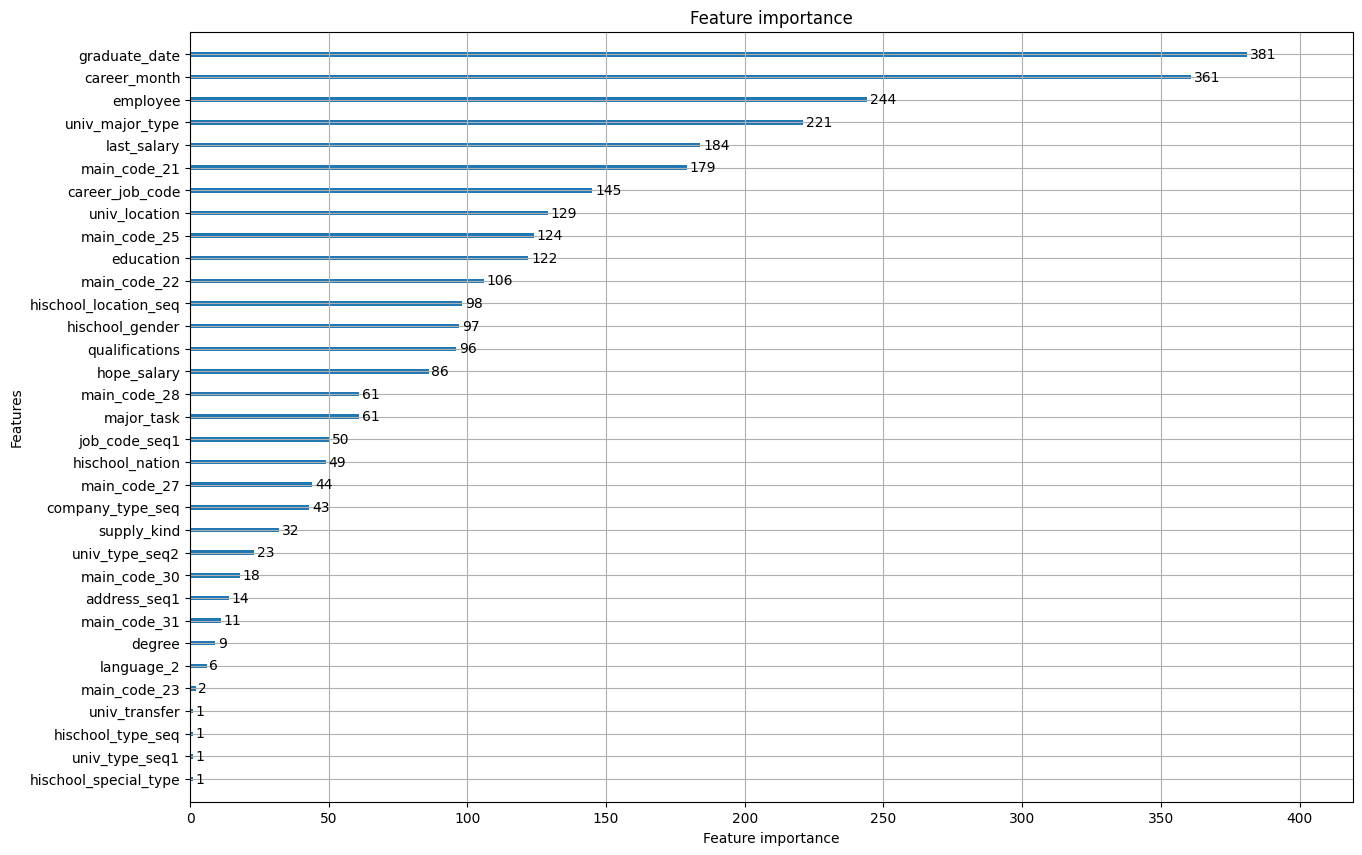

In [97]:
fig, ax  = plt.subplots(figsize = (15,10))
plot_importance(model_V0,ax=ax)
plt.show()

# 예측

In [ ]:
best_model = model_V0

In [98]:
all_recommendations = []

for resume in tqdm(resume_pool):
#for resume in tqdm(['U00001', 'U00002','U00003', 'U00004', 'U00005']):
    # 2. 임시 데이터프레임 생성
    _df_temp = pd.DataFrame({'resume_seq': [resume] * len(recruitment)})

    # 3. 전체 공고 seq를 붙임
    _df_temp['recruitment_seq'] = list(recruitment_pool)
    _df_temp.head()

    # 4. 임시 데이터프레임에 feature들 merge. 이후 구직자, 공고 id 제거 및 모델 학습
    _df_train = pd.merge(_df_temp, merged_recruitment, on='recruitment_seq', how='left')
    _df_train = pd.merge(_df_train, merged_resume, on='resume_seq', how='left')
    _df_train_drop_col = ['recruitment_seq', 'resume_seq']
    _df_train.drop(_df_train_drop_col, axis = 1, inplace=True)

    # 5. 예측 확률 계산
    pred_proba = best_model.predict_proba(_df_train)[:,1]

    # 6. 임시 데이터프레임에 예측 확률 추가하고 상위로 정렬
    _df_temp['prediction'] = pred_proba
    _df_temp = _df_temp.sort_values(by='prediction', ascending=False)

    # 7. 현재 구직자의 이미 지원한 공고 가져오기
    already_applied_jobs = apply_train[apply_train['resume_seq'] == resume]['recruitment_seq'].values

    # 8. 임시 데이터프레임에서 이미 지원한 공고를 제거
    _df_temp = _df_temp[~_df_temp['recruitment_seq'].isin(already_applied_jobs)]

    # 상위 5개 추천 (이미 지원한 공고를 제외한 상위 5개)
    top_recommendations = _df_temp.head(5)

    # 결과 출력 또는 활용
    all_recommendations.append(top_recommendations)

final_recommendations = pd.concat(all_recommendations, ignore_index=True)
final_recommendations = final_recommendations[['resume_seq', 'recruitment_seq']]
final_recommendations = final_recommendations.sort_values(by='resume_seq')
final_recommendations


100%|██████████| 8482/8482 [12:21<00:00, 11.44it/s]


,resume_seq,recruitment_seq
15249,U00001,R01071
15245,U00001,R02264
15246,U00001,R01443
15247,U00001,R03910
15248,U00001,R01047
...,...,...
27006,U08482,R00056
27007,U08482,R03502
27008,U08482,R01156
27009,U08482,R03123


# Result 저장 (Submission)

In [99]:
final_recommendations = final_recommendations[['resume_seq', 'recruitment_seq']]

In [100]:
recall5(apply_train, final_recommendations)

0.0

In [101]:
now = datetime.now() + timedelta(hours=9)
formatted_time = now.strftime("%Y%m%d_%H%M")

In [ ]:
final_recommendations.to_csv(args.default_path+ '/result/submission_'+formatted_time+'.csv', index=False)